In [72]:
import pandas as pd
from collections import Counter
import re
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


import glob
from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

from scipy import sparse
from scipy.sparse.linalg import svds


from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

import nltk
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\upadh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\upadh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
df_text_ic = pd.read_csv('../data/df_text_ic.csv')

In [19]:
df_text_ic.shape #(263941, 32)
df_text_ic.head()
# df_text_ic = df_text_ic.drop(['Unnamed: 0.1', 'Unnamed: 0'])
df_text_ic.columns

df_text_ic.head()
df_text_ic.shape #(263941, 30)
df_text_ic.columns

Index(['subject_id', 'hadm_id', 'icd', 'long_title', 'chief_complaint',
       'surgical_invasive_procedure', 'history_present_illness',
       'past_medcal_history', 'social_history', 'family_history',
       'physical_exam', 'discharge', 'pertinent_results', 'hospital_course',
       'medication_on_admission', 'medication_on_discharge',
       'discharge_disposition', 'discharge_diagnosis', 'discharge_condition',
       'discharge_instruction', 'followup_instruction', 'icd_E11', 'icd_E78',
       'icd_E87', 'icd_F32', 'icd_I16', 'icd_I50', 'icd_N17', 'icd_Y92',
       'icd_Z85'],
      dtype='object')

In [54]:
df_text_ic.head()

,subject_id,hadm_id,icd,long_title,chief_complaint,surgical_invasive_procedure,history_present_illness,past_medcal_history,social_history,family_history,...,followup_instruction,icd_E11,icd_E78,icd_E87,icd_F32,icd_I16,icd_I50,icd_N17,icd_Y92,icd_Z85
0,10000980,29654838,I50,"Congestive heart failure, unspecified",Shortness of breath\n,None\n,"___ yo woman with h/o hypertension, hyperlipid...","1. CAD RISK FACTORS: +Diabetes, +Dyslipidemia,...",___,Denies cardiac family history. Family hx of DM...,...,___\n,1,1,0,0,0,1,0,0,0
1,10000980,26913865,I50,Acute on chronic systolic heart failure,dyspnea\n,Cardiac catheterization ___\n\n,"This is a ___ M with history of diabetes, dias...",- hypertension\n- diabetes\n- hx CVA (cerebell...,___,"Niece had some sort of cancer. Otherwise, no f...",...,___\n,1,0,0,0,0,1,0,0,0
2,10000980,24947999,I50,Acute on chronic systolic heart failure,Dyspnea and chest tightness\n,___ Pharmacologic nuclear stress test\n,"___ year old female with history of HTN, HLD, ...",- hypertension \n- diabetes \n- hx CVA (cere...,___,Niece had some sort of cancer. Father died in ...,...,___\n,1,1,0,0,0,1,0,0,0
3,10000980,25242409,I50,"Congestive heart failure, unspecified",DVT\n,EGD\n\n,This is a ___ y/o female with PMHx significant...,- hypertension \n- diabetes \n- hx CVA (cere...,___,Niece had some sort of cancer. Father died in ...,...,___\n,1,1,0,0,0,1,1,1,0
4,10000980,25911675,I50,Acute on chronic systolic (congestive) heart f...,"fatigue, anemia\n",None\n\n,Ms. ___ is a ___ year old woman with a past me...,- hypertension \n- diabetes \n- hx CVA (cere...,___,Niece had some sort of cancer. Father died in ...,...,___\n,1,0,0,0,0,1,0,0,0


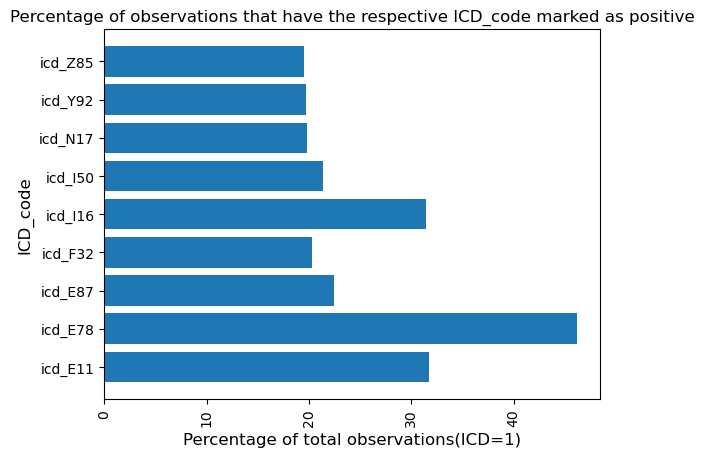

In [64]:
df = (((df_text_ic[['icd_E11', 'icd_E78',
       'icd_E87', 'icd_F32', 'icd_I16', 'icd_I50', 'icd_N17', 'icd_Y92',
       'icd_Z85']].sum())*100)/len(df_text_ic)).to_frame().reset_index().rename(columns={'index': 'ICD_code',
                                                                                         0: 'percent_Count'})

plt.barh(df.ICD_code, df.percent_Count)
plt.xticks(rotation=90)
plt.xlabel("Percentage of total observations(ICD=1)", fontsize=12)
plt.ylabel("ICD_code", fontsize=12)
plt.title("Percentage of observations that have the respective ICD_code marked as positive")
plt.show()

Text(0.5, 0, '# of categories')

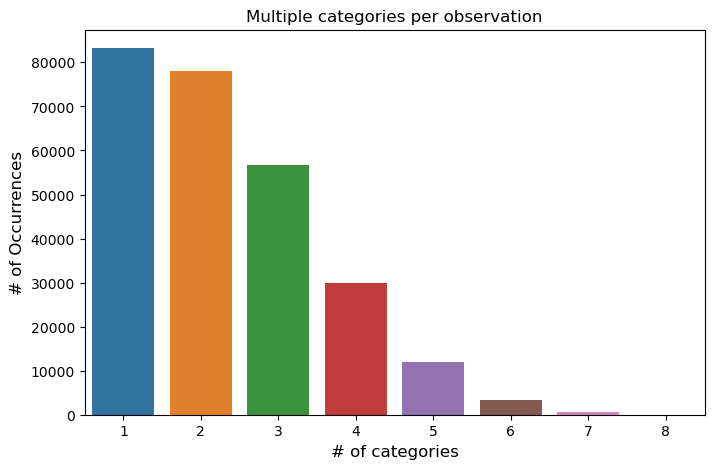

In [86]:
#how many observations have mutiple labels

rowsums = df_text_ic.loc[:,['icd_E11', 'icd_E78',
       'icd_E87', 'icd_F32', 'icd_I16', 'icd_I50', 'icd_N17', 'icd_Y92',
       'icd_Z85']].sum(axis=1)
x=rowsums.value_counts()
x
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x= x.index, y=x.values)

#how to plot broke y-axis
# f, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3,
#                              sharex=True)
# ax1 = sns.barplot(x= x.index, y=x.values, ax=ax1)
# ax2 = sns.barplot(x= x.index, y=x.values, ax=ax2)
# ax3 = sns.barplot(x= x.index, y=x.values, ax=ax3)

# ax1.set_ylim(30000, 80000)
# ax2.set_ylim(1500, 10000)
# ax3.set_ylim(0, 500)

# ax1.get_xaxis().set_visible(False)
# ax2.get_xaxis().set_visible(False)

# ax1.set_ylabel("")
# ax2.set_ylabel("")
# ax3.set_ylabel("")
# f.text(0.05, 0.55, "'# of Occurrences'", va="center", rotation="vertical")

plt.title("Multiple categories per observation")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [130]:
x

1    83254
2    78148
3    56764
4    29846
5    11960
6     3345
7      582
8       42
dtype: int64

In [87]:
print('Percentage of comments that are not labelled:')
(print(len(df_text_ic[(df_text_ic['icd_E11']==0) &
                      (df_text_ic['icd_E78']==0) & 
                      (df_text_ic['icd_E87']==0) & 
                      (df_text_ic['icd_F32']==0) & 
                      (df_text_ic['icd_I16']==0) & 
                     (df_text_ic['icd_I50']==0) &
                     (df_text_ic['icd_N17']==0) &
                     (df_text_ic['icd_Y92']==0) &
                     (df_text_ic['icd_Z85']==0)]) / len(df)))

Percentage of comments that are not labelled:
0.0


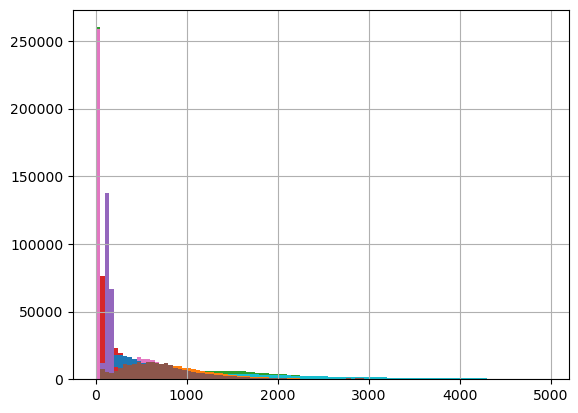

In [93]:
#The distribution of the number of words in comment texts.

text_cat = ['chief_complaint',
       'surgical_invasive_procedure', 'history_present_illness',
       'past_medcal_history', 'social_history', 'family_history',
       'physical_exam', 'discharge', 'pertinent_results', 'hospital_course',
       'medication_on_admission', 'medication_on_discharge',
       'discharge_disposition', 'discharge_diagnosis', 'discharge_condition',
       'discharge_instruction', 'followup_instruction']
import plotly.express as px
  

for i in text_cat:
    lens = df_text_ic[i].str.len()
    lens.hist(bins = np.arange(0,5000,50))
#     px.histogram(lens) 
#     fig.show()



In [53]:
#length of the string in text per column

text_cat = ['chief_complaint',
       'surgical_invasive_procedure', 'history_present_illness',
       'past_medcal_history', 'social_history', 'family_history',
       'physical_exam', 'discharge', 'pertinent_results', 'hospital_course',
       'medication_on_admission', 'medication_on_discharge',
       'discharge_disposition', 'discharge_diagnosis', 'discharge_condition',
       'discharge_instruction', 'followup_instruction']

len_dic = {}
for i in text_cat:
    avg_length = df_text_ic[i].str.len().mean()

    len_dic[i] = avg_length
    print(i, avg_length)
# pd.DataFrame(len_dic)

chief_complaint 26.63749872512023
surgical_invasive_procedure 43.27068144111782
history_present_illness 1338.3546448150678
past_medcal_history 390.9412750578889
social_history 14.60800314123099
family_history 89.78513321685958
physical_exam 650.2739529922156
discharge 545.0770224864306
pertinent_results 1207.2725091447994
hospital_course 1871.7607907286717
medication_on_admission 439.7595137824651
medication_on_discharge 857.6061432389511
discharge_disposition 11.890147247143698
discharge_diagnosis 87.73823027125779
discharge_condition 127.02810335591379
discharge_instruction 813.5096734494198
followup_instruction 4.0


In [104]:
#convert the qvg length of string text into df from dic created 
#pd.transpose() coverts row to columns.

feature_text_length = (pd.DataFrame(len_dic, index=[0])).transpose().reset_index().rename(columns= {'index':'feature_category',
                                                                             0 : 'avg_length_of_text_string'})
feature_text_length

,feature_category,avg_length_of_text_string
0,chief_complaint,26.637499
1,surgical_invasive_procedure,43.270681
2,history_present_illness,1338.354645
3,past_medcal_history,390.941275
4,social_history,14.608003
5,family_history,89.785133
6,physical_exam,650.273953
7,discharge,545.077022
8,pertinent_results,1207.272509
9,hospital_course,1871.760791


In [105]:
#the percentage of different text column (varriable) that have null values
percent_featurenull = (((df_text_ic.isna().sum())/len(df_text_ic))*100).to_frame().reset_index().rename(columns = {'index': 'feature_category',
                                                                                            0: "percent_null_observation"})
percent_featurenull

,feature_category,percent_null_observation
0,subject_id,0.000000
1,hadm_id,0.000000
2,icd,0.000000
3,long_title,0.000000
4,chief_complaint,3.415536
5,surgical_invasive_procedure,0.433809
6,history_present_illness,1.795098
7,past_medcal_history,1.664008
8,social_history,2.544887
9,family_history,2.847985


In [108]:
df_feastats = feature_text_length.merge(percent_featurenull, on=('feature_category'))
df_feastats

,feature_category,avg_length_of_text_string,percent_null_observation
0,chief_complaint,26.637499,3.415536
1,surgical_invasive_procedure,43.270681,0.433809
2,history_present_illness,1338.354645,1.795098
3,past_medcal_history,390.941275,1.664008
4,social_history,14.608003,2.544887
5,family_history,89.785133,2.847985
6,physical_exam,650.273953,4.459330
7,discharge,545.077022,98.534142
8,pertinent_results,1207.272509,3.363631
9,hospital_course,1871.760791,12.450889


In [ ]:
#thoughts and flow
#identifing right variable for doing/predicating MULTILABEL CLASSIFICATION
#1. take one variable column to get tokens at a time and one icd
#2. take one variable column to get tokens at a time and all icd 
#3. take different variable columns and predict one icd
#4. take different variable columns and predict all icd
#5. concat all the column with the discharge label and usefor classification

#supervised classifiers and text representations


# categories = ['icd_E11', 'icd_E78','icd_E87', 'icd_F32', 'icd_I16', 'icd_I50', 'icd_N17', 'icd_Y92','icd_Z85']
# variables = [ 'history_present_illness',
#        'past_medcal_history', 'social_history', 'family_history',
#        'physical_exam', 'discharge', 'pertinent_results', 'hospital_course',
#        'medication_on_admission', 'medication_on_discharge',
#        'discharge_disposition', 'discharge_diagnosis', 'discharge_condition',
#        'discharge_instruction', 'followup_instruction']
# x=df[variables]
# y=df[target]

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y)

In [132]:
#dropping the discharge column as it is 98% null
df4model = df_text_ic.drop('discharge', axis=1).fillna('')

In [133]:
df4model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263941 entries, 0 to 263940
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   subject_id                   263941 non-null  int64 
 1   hadm_id                      263941 non-null  int64 
 2   icd                          263941 non-null  object
 3   long_title                   263941 non-null  object
 4   chief_complaint              263941 non-null  object
 5   surgical_invasive_procedure  263941 non-null  object
 6   history_present_illness      263941 non-null  object
 7   past_medcal_history          263941 non-null  object
 8   social_history               263941 non-null  object
 9   family_history               263941 non-null  object
 10  physical_exam                263941 non-null  object
 11  pertinent_results            263941 non-null  object
 12  hospital_course              263941 non-null  object
 13  medication_on_

In [151]:
categories = ['icd_E11', 'icd_E78','icd_E87', 'icd_F32', 'icd_I16', 'icd_I50', 'icd_N17', 'icd_Y92','icd_Z85']

variables = [ 'history_present_illness', 'past_medcal_history', 'social_history', 'family_history',
       'physical_exam', 'pertinent_results', 'hospital_course',
       'medication_on_admission', 'medication_on_discharge',
       'discharge_disposition', 'discharge_diagnosis', 'discharge_condition',
       'discharge_instruction', 'followup_instruction'] 

# df4model['dis_mer'] = df4model['discharge_disposition']+ df4model['discharge_diagnosis'] #these are object do we need to use astype(str)

train, test = train_test_split(df4model, random_state=42, test_size=0.33, shuffle=True)
X_train = train.discharge_instruction
X_test = test.discharge_instruction
y_train = train[categories]
y_test = test[categories]

print(X_train.shape)
print(X_test.shape)

(176840,)
(87101,)


In [ ]:

vector = CountVectorizer(stop_words=stopwords.words('english')) #doing countvectorizer after removing stop words

vector.fit(X_train)
X_train_vector = vector.transform(X_train)

X_test_vector = vector.transform(X_test)

NB = MultinomialNB().fit(X_train_vector, y_train)

y_pred = NB.predict(X_test_vector)

print(accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

In [152]:
# traing classifier

# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

var_pre = {}


for category in categories:
    print('... Processing {}'.format(category))
    
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    var_pre[category] = prediction
    
    
#     print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

nb_pred = pd.DataFrame(var_pre)

print(nb_pred)

... Processing icd_E11
... Processing icd_E78
... Processing icd_E87
... Processing icd_F32
... Processing icd_I16
... Processing icd_I50
... Processing icd_N17
... Processing icd_Y92
... Processing icd_Z85
       icd_E11  icd_E78  icd_E87  icd_F32  icd_I16  icd_I50  icd_N17  icd_Y92  \
0            0        1        0        0        0        0        0        0   
1            0        0        0        0        1        0        0        0   
2            0        0        0        0        0        0        0        0   
3            0        0        0        0        0        0        1        0   
4            0        0        0        0        0        0        0        0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
87096        0        0        1        0        0        0        0        0   
87097        0        0        0        0        0        0        0        0   
87098        0        0        1        0        0        0     

In [155]:
y_test.head(10)

,icd_E11,icd_E78,icd_E87,icd_F32,icd_I16,icd_I50,icd_N17,icd_Y92,icd_Z85
4039,0,1,0,0,1,1,0,0,0
196957,0,0,0,1,1,0,0,1,0
68719,1,1,0,0,1,0,0,0,0
18633,0,1,0,0,0,1,1,0,0
92713,1,0,0,0,0,0,0,0,0
223557,0,0,0,0,1,0,0,0,0
180840,0,0,1,0,0,0,1,1,0
191240,0,0,0,1,0,0,0,0,0
33080,1,1,0,1,1,1,0,0,0
29771,1,1,0,0,0,1,0,0,0


In [153]:
nb_pred.head(10)

,icd_E11,icd_E78,icd_E87,icd_F32,icd_I16,icd_I50,icd_N17,icd_Y92,icd_Z85
0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0
7,0,0,0,1,0,0,0,0,0
8,1,1,0,0,0,1,1,0,0
9,0,1,0,0,0,0,0,0,0


In [136]:
from sklearn.multioutput import MultiOutputClassifier

NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
                ('clf', MultiOutputClassifier(MultinomialNB(fit_prior=True, class_prior=None))),
            ])
# for category in categories:
# prit('... Processing {}'.format(category))
    
NB_pipeline.fit(X_train, train[categories])
    # compute the testing accuracy
prediction = NB_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(test[categories], prediction)))

Test accuracy is 0.06173293073558283


In [ ]:
# traing classifier

# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

In [150]:
confusion_matrix(test[categories].values[:,8], prediction[:,8])

# test[categories].values[:,0]

array([[69563,   398],
       [16873,   267]], dtype=int64)

In [145]:
NB_pipeline.predict_proba(X_test)

[array([[0.67129963, 0.32870037],
        [0.91925506, 0.08074494],
        [0.67378768, 0.32621232],
        ...,
        [0.69917087, 0.30082913],
        [0.70876549, 0.29123451],
        [0.57777758, 0.42222242]]),
 array([[0.29406301, 0.70593699],
        [0.65383062, 0.34616938],
        [0.52985017, 0.47014983],
        ...,
        [0.67020318, 0.32979682],
        [0.62010217, 0.37989783],
        [0.43085946, 0.56914054]]),
 array([[0.96317245, 0.03682755],
        [0.99522349, 0.00477651],
        [0.85350075, 0.14649925],
        ...,
        [0.4559544 , 0.5440456 ],
        [0.42765355, 0.57234645],
        [0.78609214, 0.21390786]]),
 array([[0.94684227, 0.05315773],
        [0.98123706, 0.01876294],
        [0.88475992, 0.11524008],
        ...,
        [0.83197805, 0.16802195],
        [0.89397472, 0.10602528],
        [0.90149275, 0.09850725]]),
 array([[0.61980258, 0.38019742],
        [0.14460352, 0.85539648],
        [0.67973693, 0.32026307],
        ...,
        [

In [127]:
#checking how the text looks like in the variable column 
df4model['discharge_instruction'].iloc[10]

'Dear Ms. ___,\n\nIt was a pleasure taking care of you.\n\nWHY WAS I ADMITTED TO THE HOSPITAL?\nYou had a diabetic foot ulcer on your left toe that was very \ninfected and had caused an infection in your bone.\n\nWHAT WAS DONE WHILE I WAS HERE?\nYour big left toe was removed because you had a bad bone \ninfection. You were treated with antibiotics to fight the \ninfection and will need to go home on IV antibiotics.\n\nWHAT DO I NEED TO DO WHEN I LEAVE?\nPlease continue to take your medications as directed.  You will \ngo home with an antibiotic infusion pump and will have a \nvisiting nurse come to your house to teach you how to use it.  \nYou will need to administer antibiotics through the pump every 4 \nhours.  We changed your diabetic medication regimen, so please \nfollow along as instructed below and keep close track of your \nsugars at home. Check your sugars 4 times a day and log the \nresults. Bring the results in with you to your ___ \nappointment on ___ at 1:00 pm so that the

In [125]:
# celaning the text in the columns
(df4model['dis_mer'].str.replace('\n', '')
.str.replace('=', '')
.str.replace('-', '')
.str.replace('_', ''))

0         Home With Service Hypertension with hypertensi...
1         Home With Service PRIMARY DIAGNOSIS:Severe mit...
2         Home With Service Primary Diagnosis: Acute on ...
3          Extended Care Primary:Deep vein thrombosis (DVT)
4         Home With Service Primary diagnosis:AnemiaCong...
                                ...                        
263936                                                  NaN
263937    Home With Service Primary DiagnosisHypotension...
263938    Extended Care PRIMARY DIAGNOSIS1. Variceal ble...
263939                                                  NaN
263940    Home Final Diagnosis: SIADH, Hyponatremia febr...
Name: dis_mer, Length: 263941, dtype: object